Observation shape: (1, 320)
Step 0:


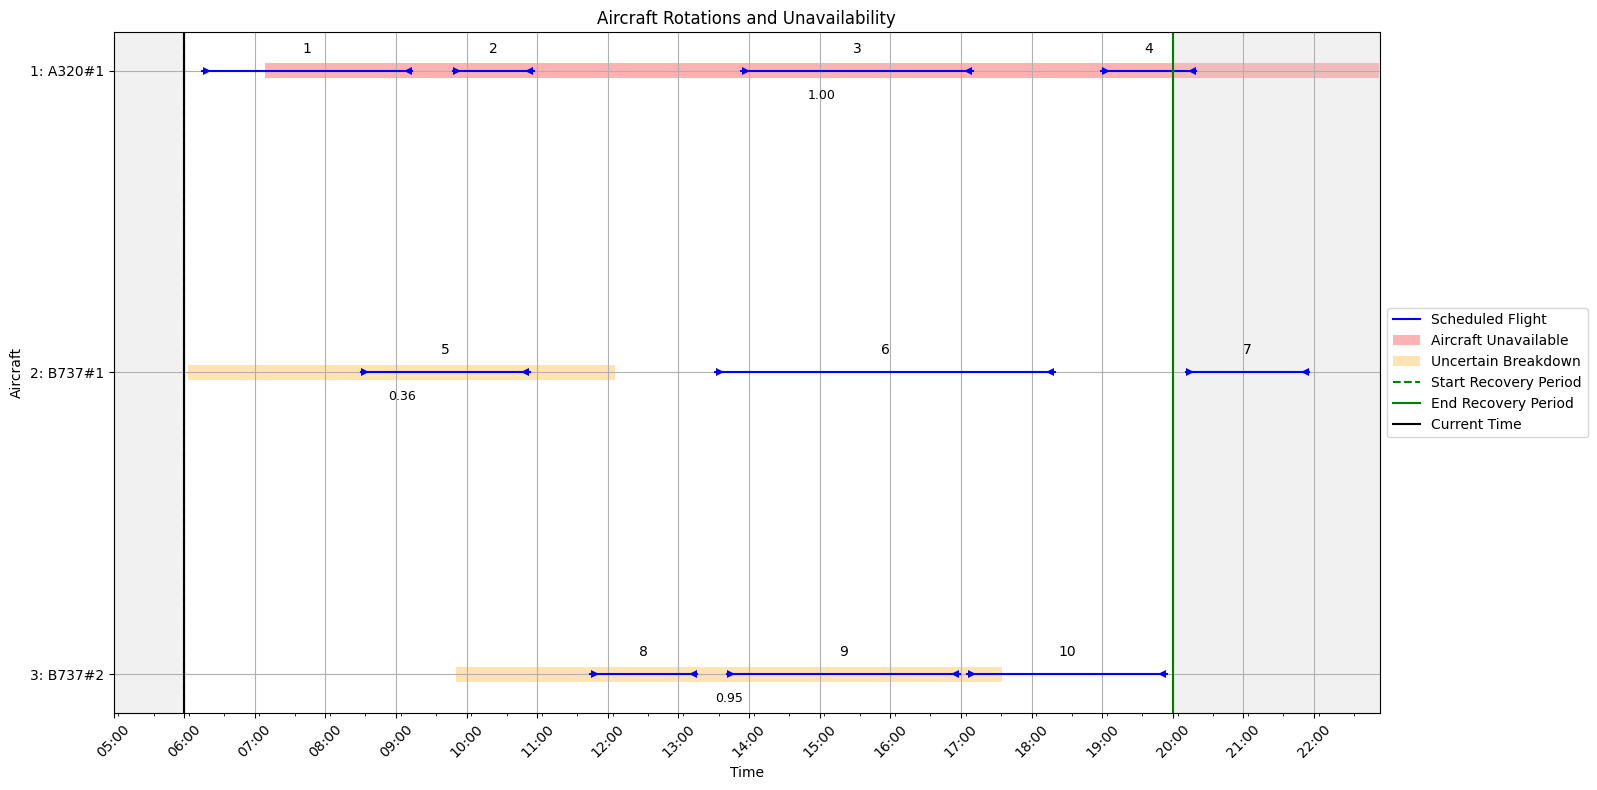

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          1         │          2         │          0         │         840        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00     69  1015 |     1    15   194 |     2   228   297 |     3   473   670 |     4   779   860 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.36      4   366 |     5   150   294 |     6   451   740 |     7   851   956 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.95    231   695 |     8

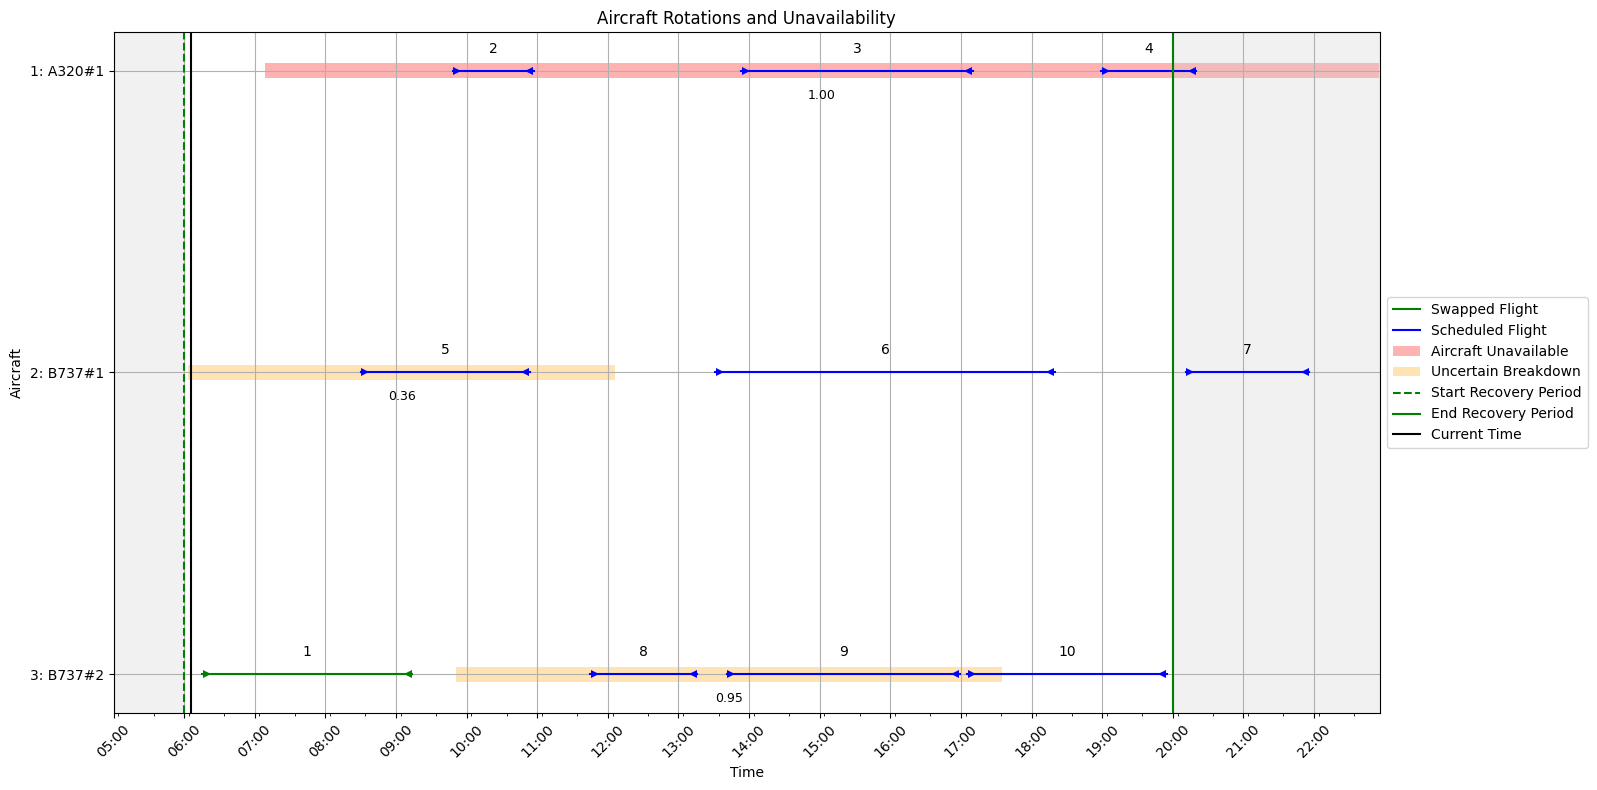

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          1         │          2         │          6         │         834        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00     69  1015 |     2   228   297 |     3   473   670 |     4   779   860 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.36      4   366 |     5   150   294 |     6   451   740 |     7   851   956 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.95    231   695 |     1

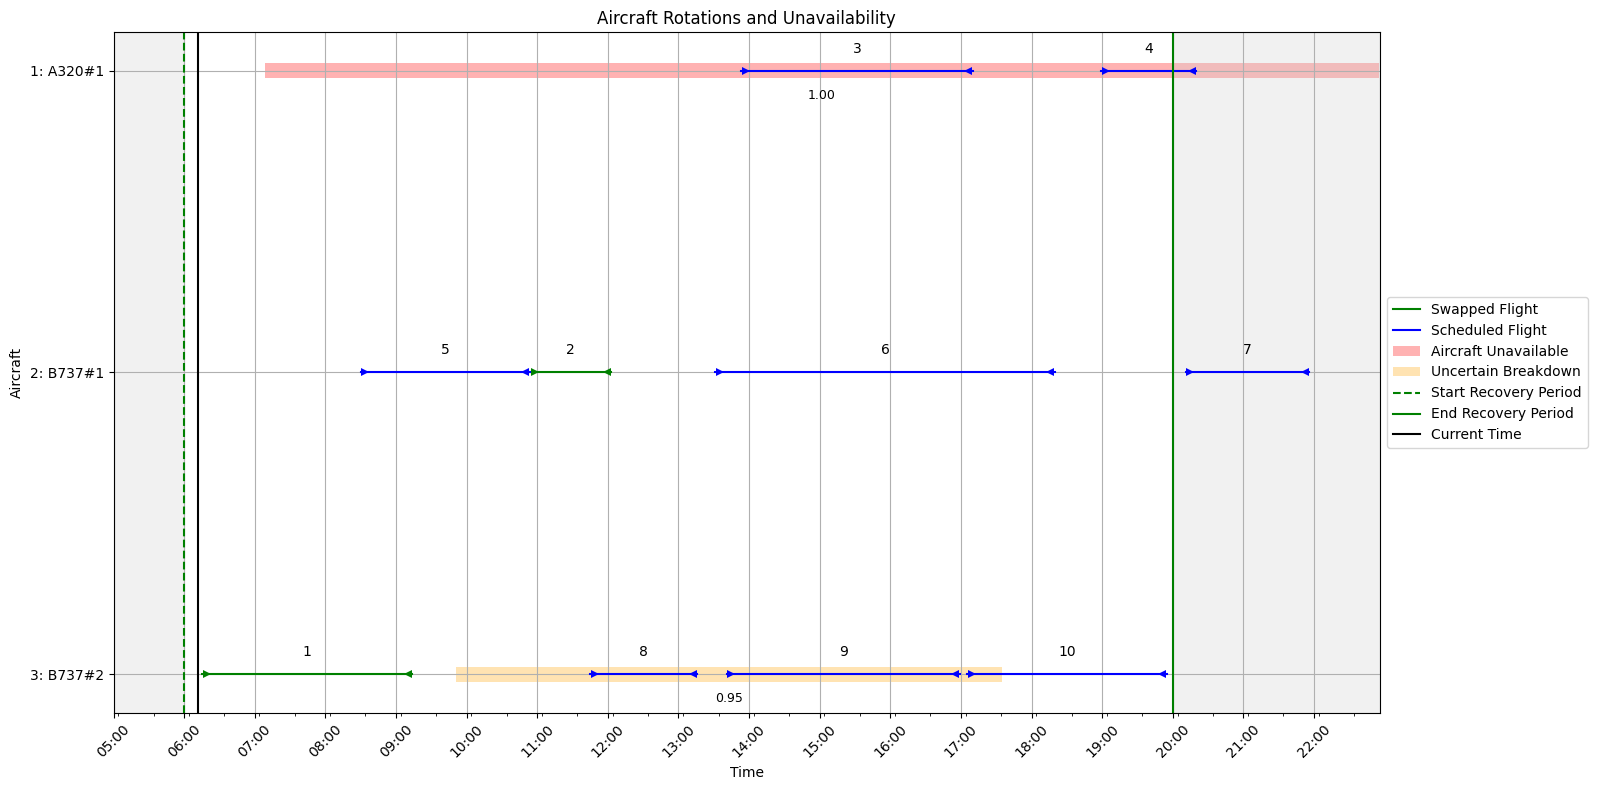

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          1         │          3         │         12         │         828        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00     69  1015 |     3   473   670 |     4   779   860 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.00      -     - |     5   150   294 |     2   294   363 |     6   451   740 |     7   851   956 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.95    231   695 |     1

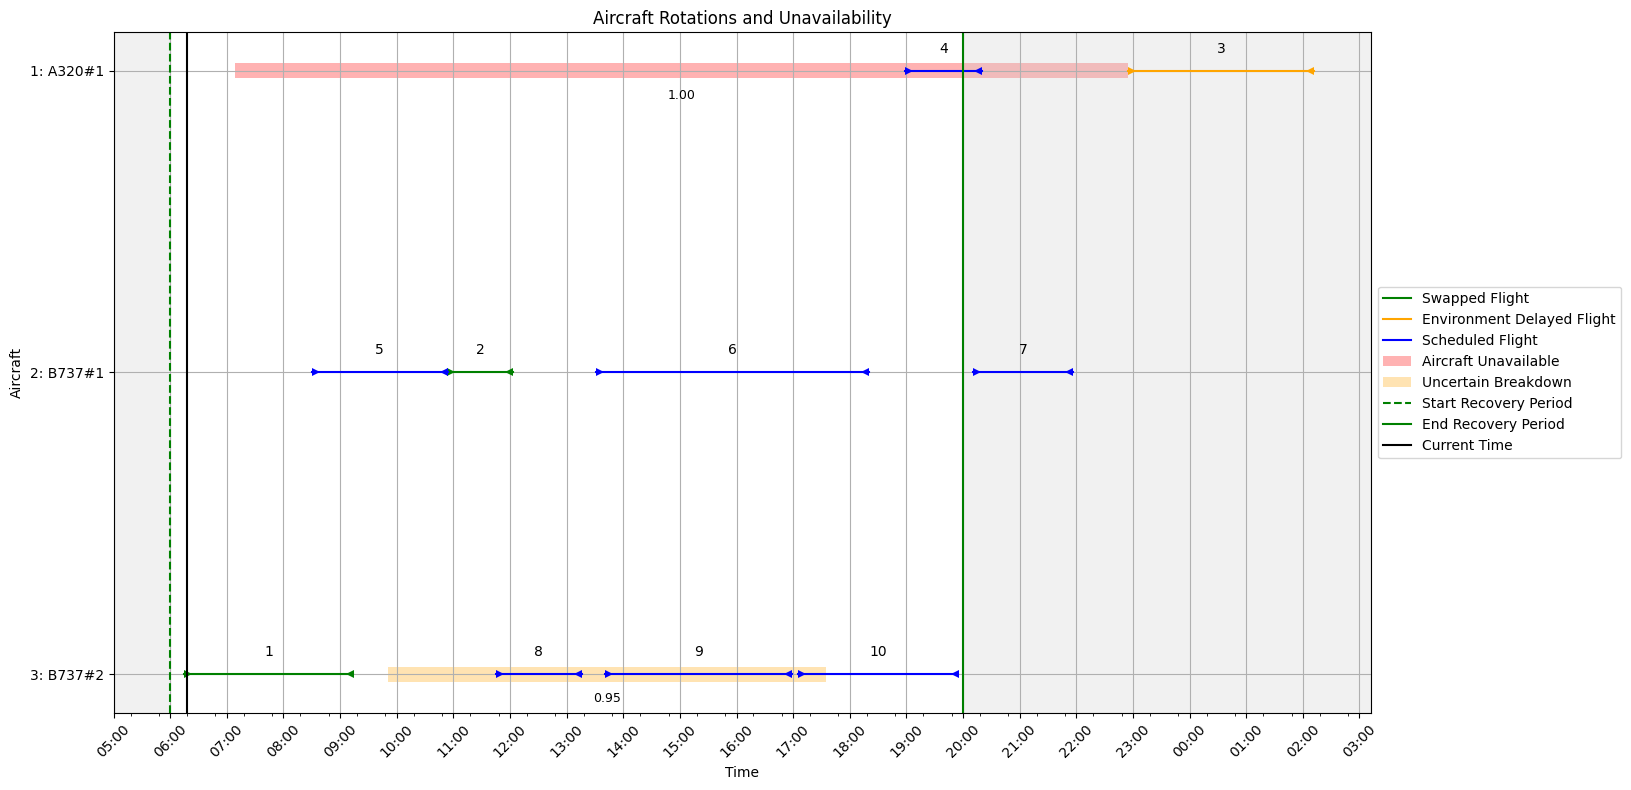

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          1         │          4         │         18         │         822        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00     69  1015 |     4   779   860 |     3  1015  1212 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.00      -     - |     5   150   294 |     2   294   363 |     6   451   740 |     7   851   956 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.95    231   695 |     1

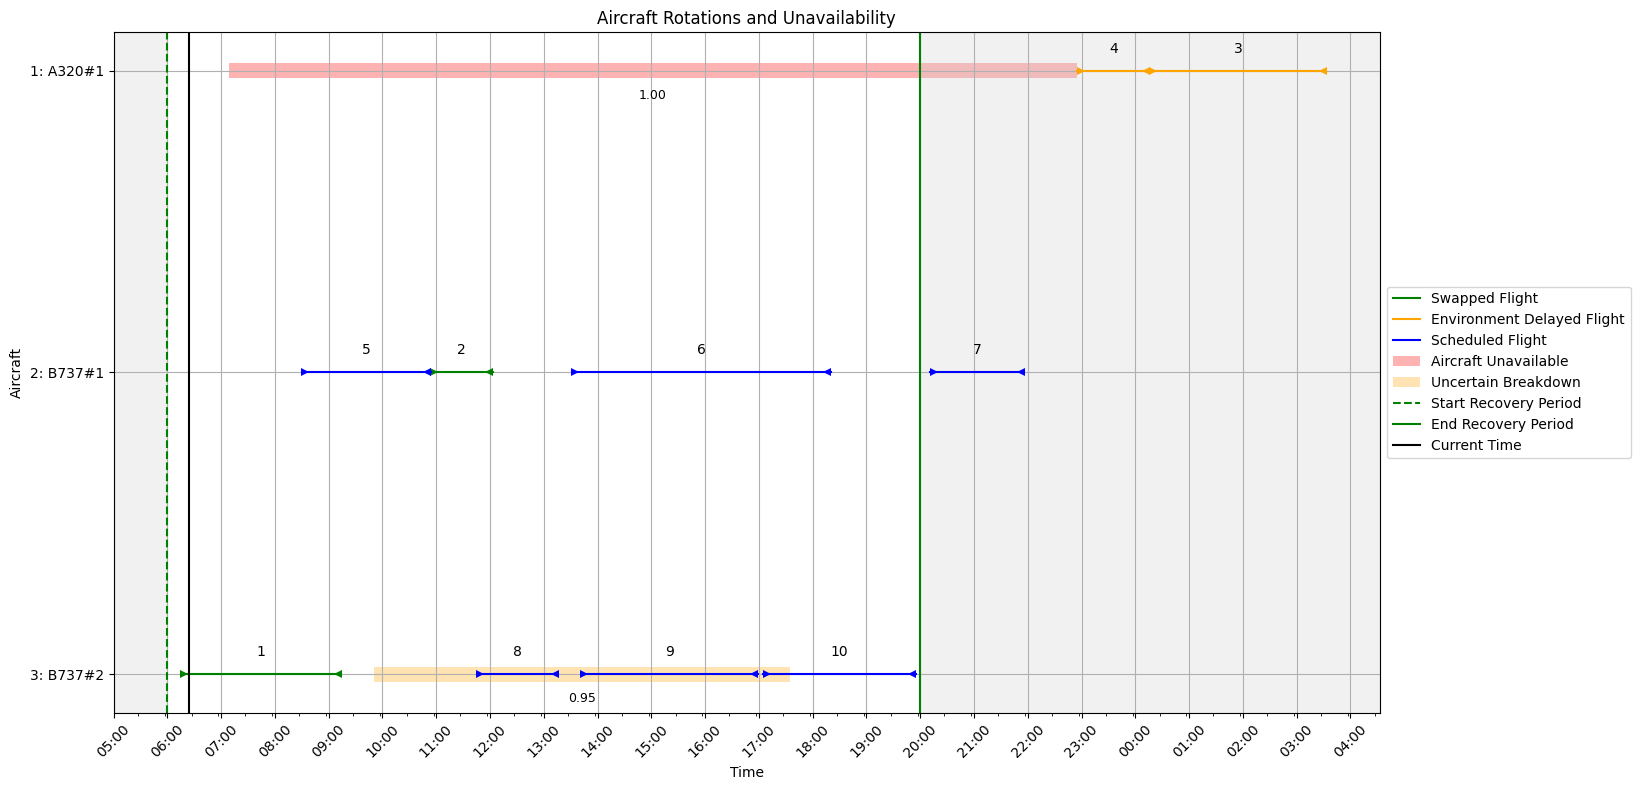

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          -         │          -         │         24         │         816        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00     69  1015 |     4  1015  1096 |     3  1096  1293 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.00      -     - |     5   150   294 |     2   294   363 |     6   451   740 |     7   851   956 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.95    231   695 |     1

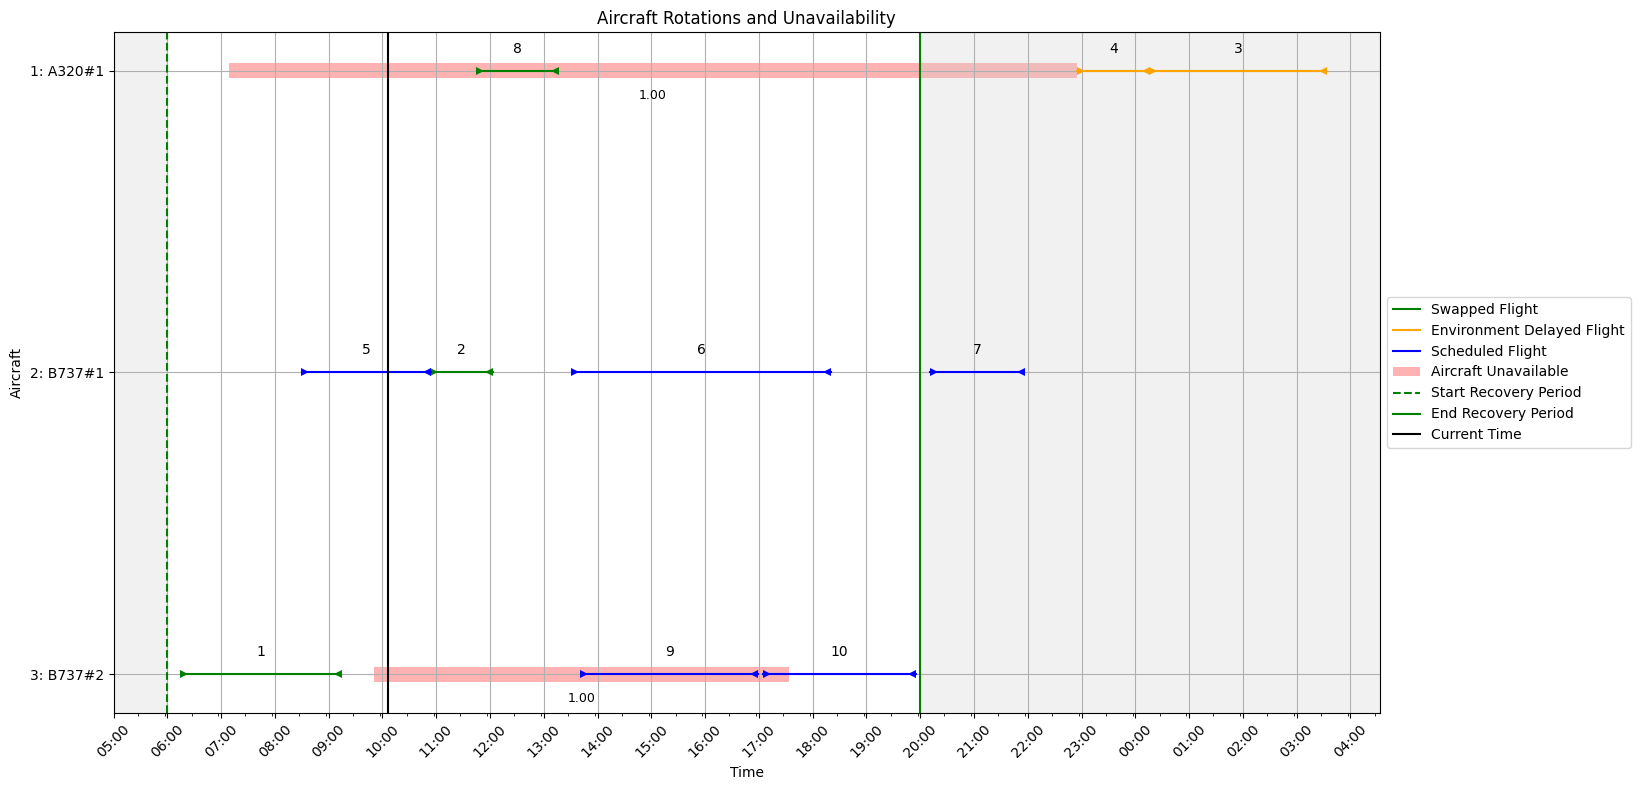

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          1         │          8         │         246        │         594        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00     69  1015 |     8   345   436 |     4  1015  1096 |     3  1096  1293 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.00      -     - |     5   150   294 |     2   294   363 |     6   451   740 |     7   851   956 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00    231   694 |     1

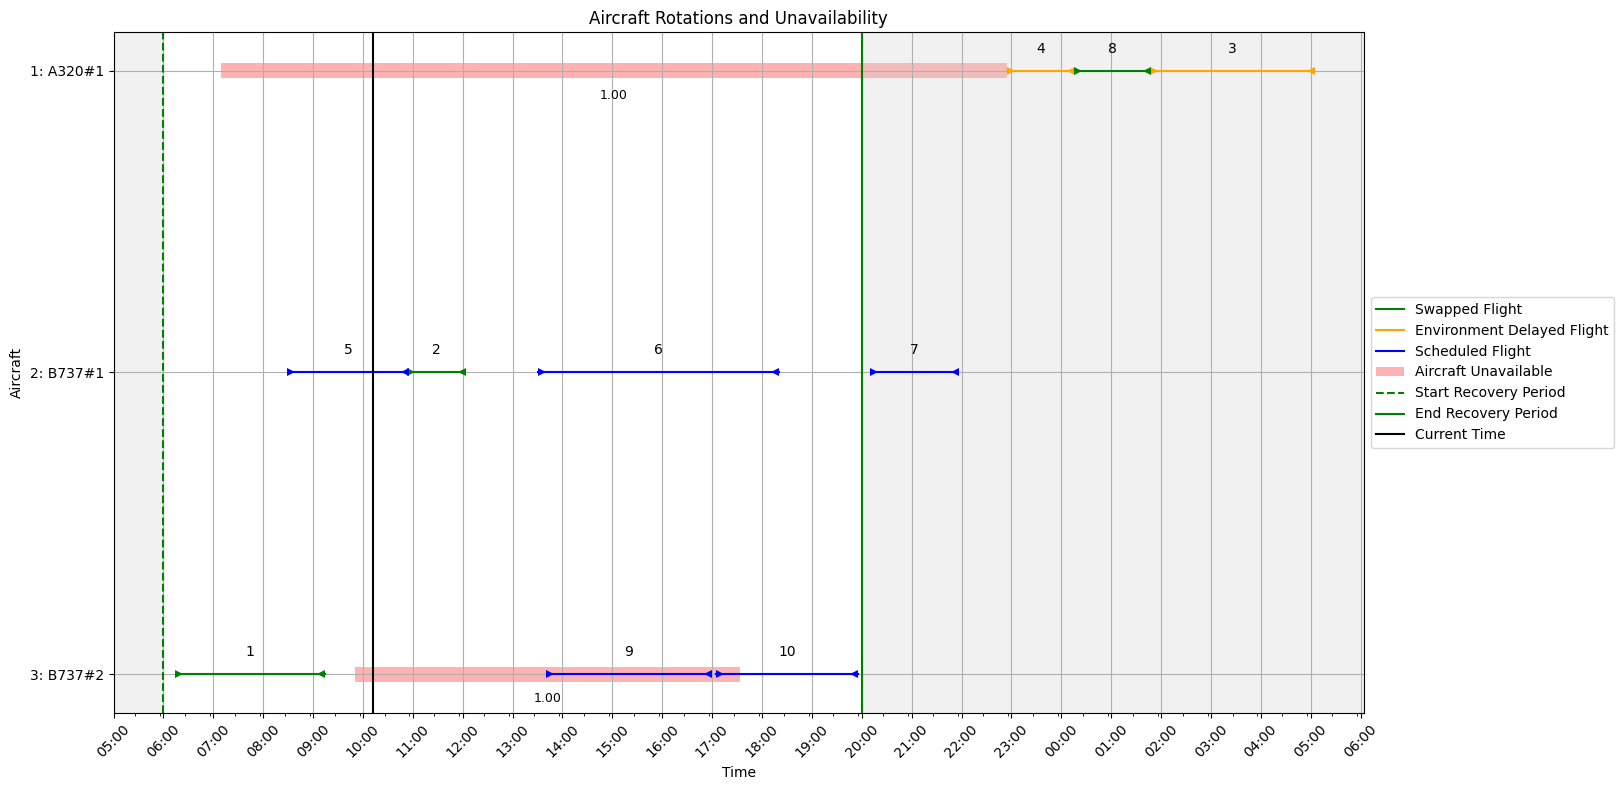

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          3         │          9         │         252        │         588        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00     69  1015 |     4  1015  1096 |     8  1096  1187 |     3  1187  1384 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.00      -     - |     5   150   294 |     2   294   363 |     6   451   740 |     7   851   956 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00    231   694 |     1

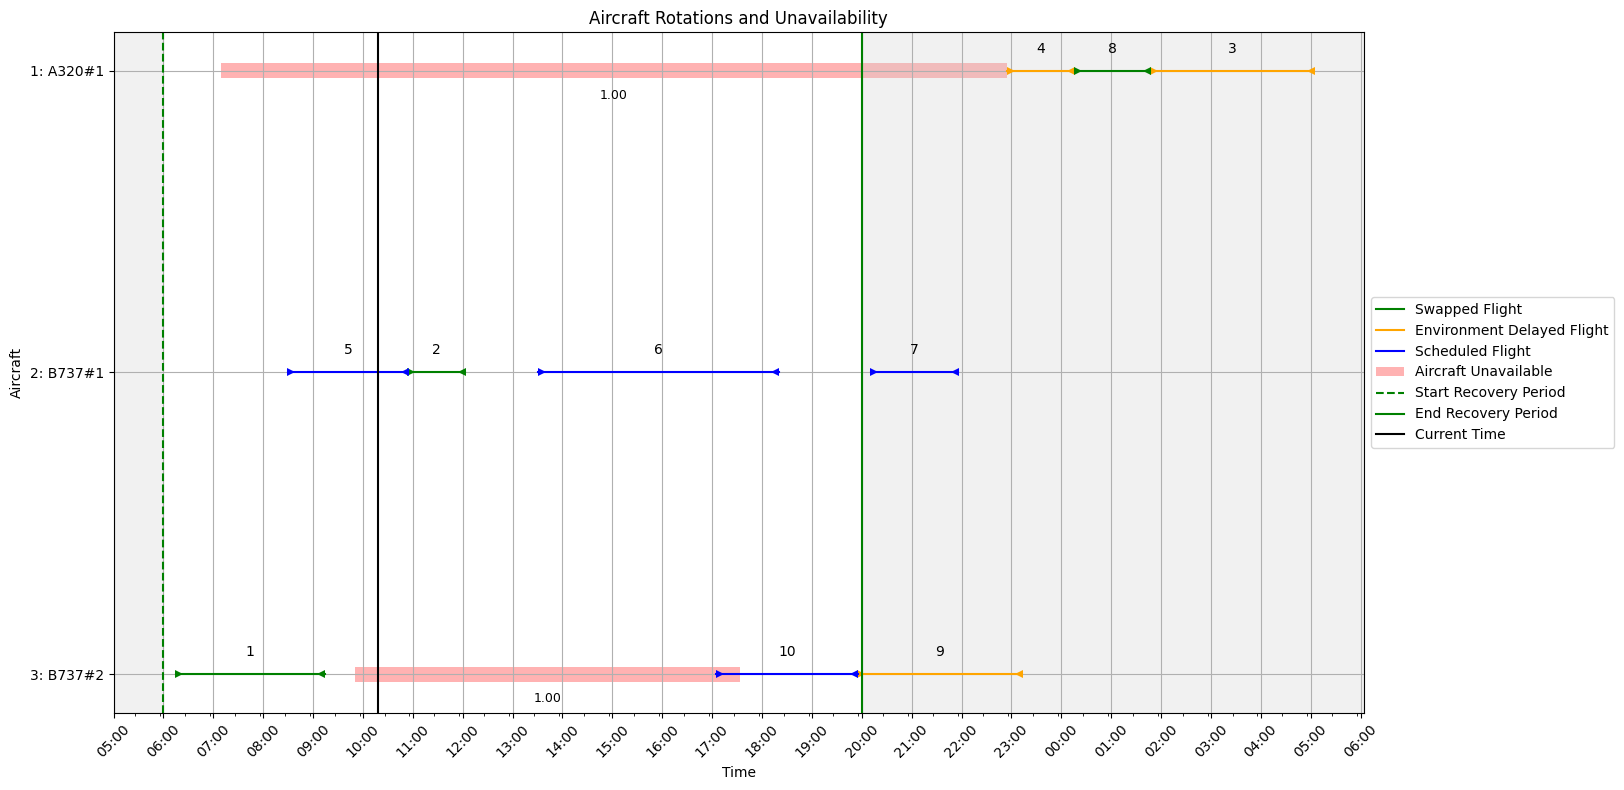

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          3         │         10         │         258        │         582        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00     69  1015 |     4  1015  1096 |     8  1096  1187 |     3  1187  1384 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.00      -     - |     5   150   294 |     2   294   363 |     6   451   740 |     7   851   956 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00    231   694 |     1

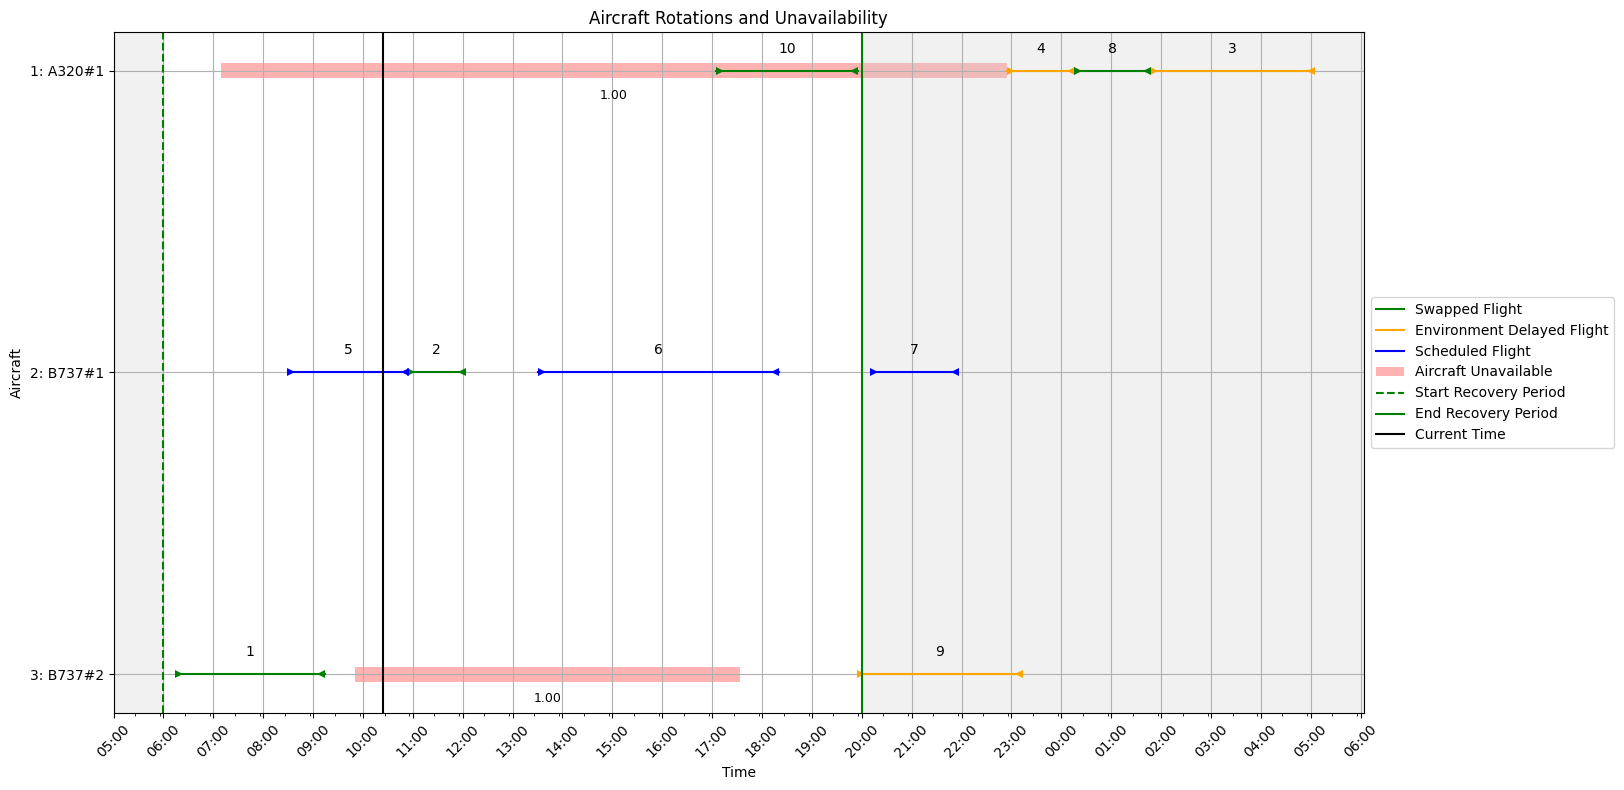

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          1         │         10         │         264        │         576        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00     69  1015 |    10   665   835 |     4  1015  1096 |     8  1096  1187 |     3  1187  1384 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.00      -     - |     5   150   294 |     2   294   363 |     6   451   740 |     7   851   956 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00    231   694 |     1

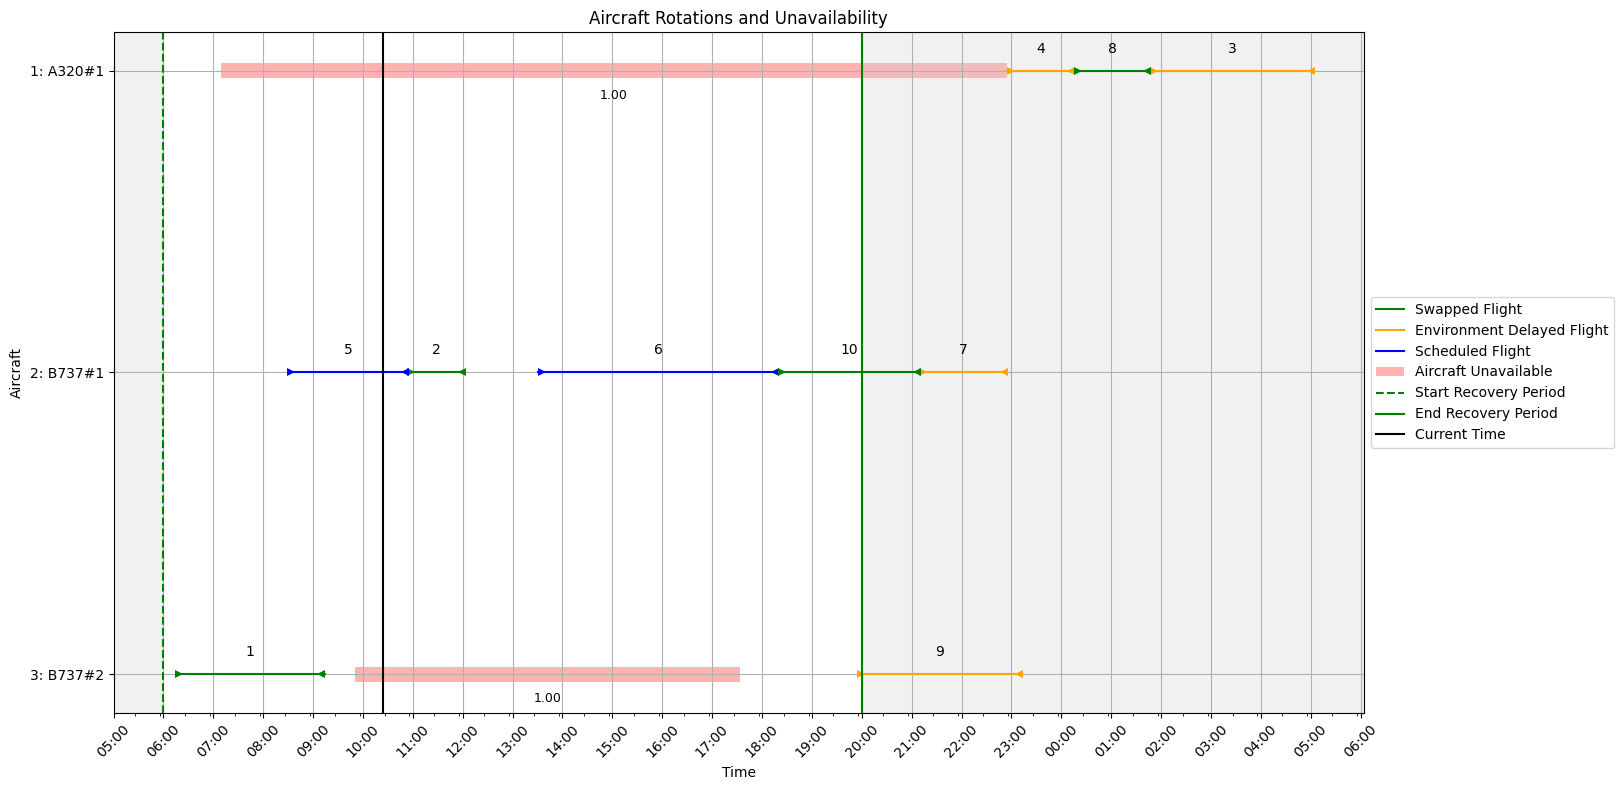

Total Reward: -3618.0


In [3]:
import os
import numpy as np
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter


# Run the random agent
def run_random_agent(scenario_folder):
    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)
    env = DummyVecEnv([lambda: env])

    # Reset the environment
    obs = env.reset()
    print("Observation shape:", obs.shape)

    done = False
    total_reward = 0
    step_num = 0

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=aircraft_dict,
        flights_dict=flights_dict,
        rotations_dict=rotations_dict,
        alt_aircraft_dict=alt_aircraft_dict,  # Initial alt_aircraft_dict
        start_datetime=env.get_attr('start_datetime')[0],
        end_datetime=env.get_attr('end_datetime')[0],
        uncertain_breakdowns=env.get_attr('uncertain_breakdowns')[0],
    )

    while not done:
        # Visualize the environment at each step
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.get_attr('swapped_flights')[0]
        environment_delayed_flights = env.get_attr('environment_delayed_flights')[0]
        current_datetime = env.get_attr('current_datetime')[0]

        # Retrieve the updated flights_dict from the environment
        updated_flights_dict = env.get_attr('flights_dict')[0]
        cancelled_flights = env.get_attr('penalized_cancelled_flights')[0]

        # Retrieve the updated alt_aircraft_dict from the environment
        updated_alt_aircraft_dict = env.get_attr('alt_aircraft_dict')[0]

        if DEBUG_MODE_VISUALIZATION:
            print("Flights Dict:")
            print(updated_flights_dict)
            print("Alt Aircraft Dict:")
            print(updated_alt_aircraft_dict)
            print("Swapped Flights:")
            print(swapped_flights)
            print("Environment Delayed Flights:")
            print(environment_delayed_flights)
            print("Cancelled Flights:")
            print(cancelled_flights)
            print("Unavailabilities:")
            print(env.get_attr('alt_aircraft_dict')[0])
            print("Uncertain Breakdowns:")
            for key, value in env.get_attr('uncertain_breakdowns')[0].items():
                print(f"{key}: {value}")
            print("Current Breakdowns:")
            print(env.get_attr('current_breakdowns')[0])
            print("")
        # Update the StatePlotter's alt_aircraft_dict
        state_plotter.alt_aircraft_dict = updated_alt_aircraft_dict

        # Plot the state using the updated alt_aircraft_dict
        state_plotter.plot_state(
            updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
        )

        # Sample a random action
        action = np.random.randint(0, env.action_space.n, size=env.num_envs)
        # action = [0]  # Always no action

        # Step the environment
        obs, rewards, dones, infos = env.step(action)

        # Extract values from arrays
        reward = rewards[0]
        done = dones[0]

        # Accumulate the reward
        total_reward += reward

        # print(f"Action taken: {action}, Reward: {reward}")
        print("")

        step_num += 1

    # Final plot after the simulation ends
    state_plotter.plot_state(
        updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
    )

    print(f"Total Reward: {total_reward}")

SCENARIO_FOLDER = "../Data/Testing/1k-3ac-12f-1dis-F/Scenario_01"
# SCENARIO_FOLDER = "../data/Example/Busy-scenario"

# Verify folder exists
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

# Run the random agent
run_random_agent(SCENARIO_FOLDER)
